In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import numpy as np
import pandas as pd
import torch
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ml_confs
from tqdm.notebook import tqdm

from NCP.cde_fork.density_simulation import LinearGaussian, ArmaJump, SkewNormal, EconDensity, GaussianMixture, JumpDiffusionModel

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)  

Ntrain = 10000
Nval = 1000
Ntest = 100

In [52]:
from scipy.special import rel_entr
import lightning as L

# Class for preventing the wall of text
# https://github.com/Lightning-AI/pytorch-lightning/issues/15283
class LitProgressBar(L.pytorch.callbacks.TQDMProgressBar):
    def init_validation_tqdm(self):
        # bar = super().init_validation_tqdm()
        bar = tqdm(disable=True,)
        # bar.disable = True
        return bar

    def init_train_tqdm(self):
        bar = tqdm()
        bar.dynamic_ncols = False
        bar.ncols = 0
        bar.bar_format ='{desc} [{rate_fmt}{postfix}]'
        return bar

def pdf2cdf(pdf, step):
    return np.cumsum(pdf * step, -1)

def normalize(x):
    return x/x.sum()

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = model.pdf(x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        # true_pdf = density_simulator.pdf(x, yscaler.inverse_transform(y).T)
        true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform(x[..., None]), scale=sigma_sq)
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

def empirical_H(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = model.pdf(x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform(x[..., None]), scale=sigma_sq)
        
        scores.append(hellinger(true_pdf, pred_pdf))
    return scores


def KL(p, q):
    eps = np.finfo(p.dtype).eps
    p = np.where(p < eps, eps, p)
    q = np.where(q < eps, eps, q)
    
    p = normalize(p)
    q = normalize(q)
    
    return np.sum(rel_entr(p, q))

## Linear gaussian

In [53]:
L.seed_everything(0)

X = np.random.normal(0, 1, Ntrain+Nval+Ntest)
from math import sqrt
sigma_sq = .5
Y = X + np.random.normal(0, sigma_sq, X.shape[0])

p_x = lambda x: (1/sqrt(2*np.pi)) * np.exp(-(x**2)/2)
p_y = lambda y: (1/(sqrt(2*np.pi)*sqrt(1+sigma_sq))) * np.exp(-(y**2)/(2*(1+sigma_sq)))

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

Seed set to 0


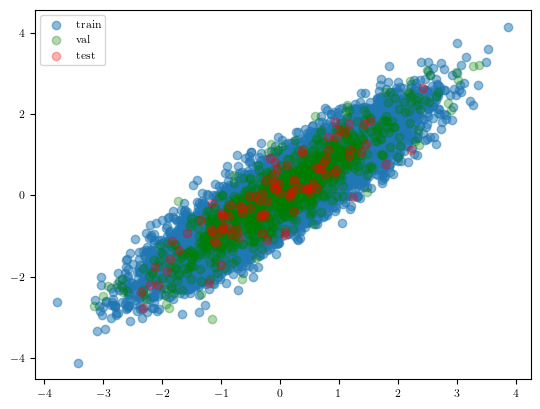

In [54]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [89]:
from NCP.model import NCPModule
from torch.utils.data import DataLoader, TensorDataset
from NCP.nn.losses import CMELoss
from NCP.model import NCPOperator
from NCP.layers import MLP
from NCP.utils import frnp

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0it [00:00, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/gturri/miniconda3/envs/NCP/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/gturri/miniconda3/envs/NCP/lib/python3.11/multiprocessing/connection.py", line 178, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/gturri/miniconda3/envs/NCP/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    self._close()
  File "/home/gturri/miniconda3/envs/NCP/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    reader_close()
  File "/home/gturri/miniconda3/envs/NCP/lib/python3.11/multiprocessing/connection.py", line 178, in close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/gturri/miniconda3/envs/NCP/lib/python3.11/threading.py", line 1045, in _bootstrap_inn

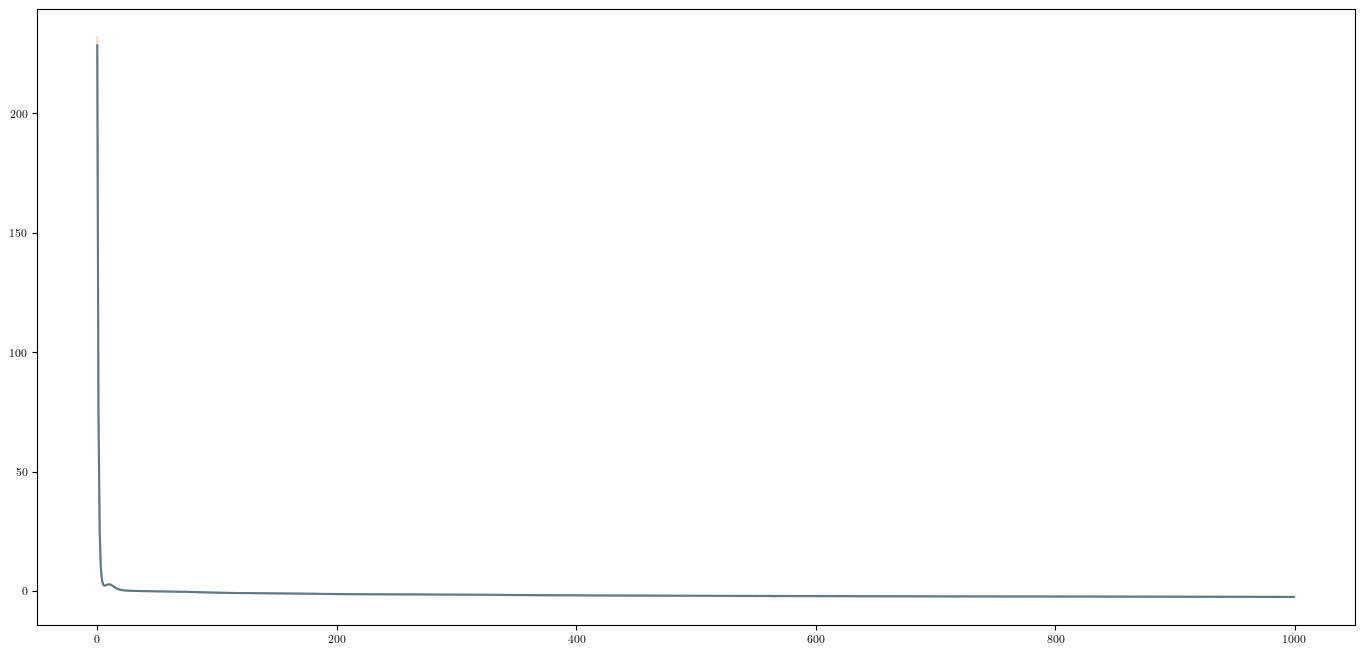

In [91]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
# plt.yscale('log')
plt.show()

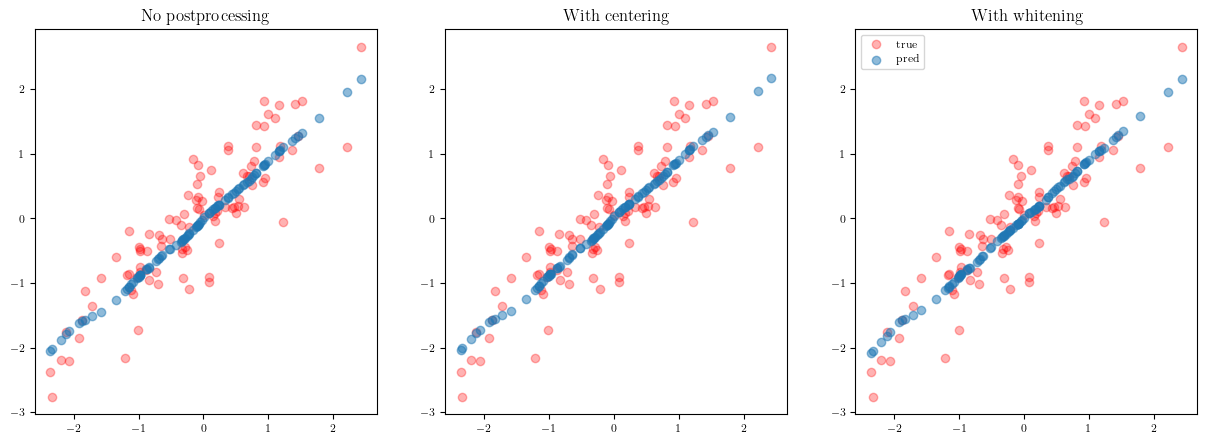

In [92]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

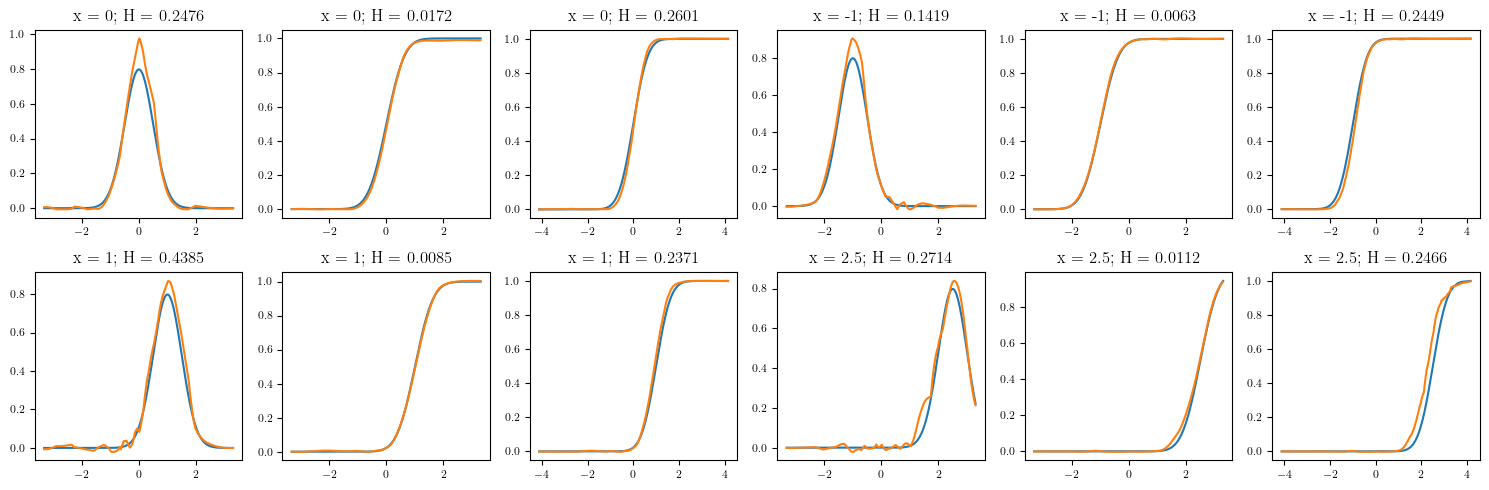

In [93]:
from scipy.stats import norm
from NCP.cdf import compute_marginal
from NCP.metrics import *

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate([0, -1, 1, 2.5]):
    x_scaled = frnp(xscaler.transform([[xi]]))
    fys, pred_pdf = NCP_model.pdf(x_scaled, ys, p_y=p_y, postprocess=postprocess)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = norm.pdf(fys, loc=xi, scale=sigma_sq)
    axes[i*3].plot(fys, true_pdf)
    axes[i*3].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    fys2, pred_cdf2 = NCP_model.cdf(x_scaled, frnp(Y_train), postprocess=postprocess)
    true_cdf = norm.cdf(fys, loc=xi, scale=sigma_sq)
    true_cdf2 = norm.cdf(fys2, loc=xi, scale=sigma_sq)
    axes[i*3+1].plot(fys, true_cdf)
    axes[i*3+1].plot(fys, pred_cdf)
    axes[i*3+2].plot(fys2, true_cdf2)
    axes[i*3+2].plot(fys2, pred_cdf2)

    axes[i*3].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    axes[i*3+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))
    axes[i*3+2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf2, pred_cdf2, fys2)))

plt.tight_layout()
plt.show()

In [94]:
p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=20)
ys, step = np.linspace(-2, 2, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'whitening'
scores_pdf = []
scores_cdf = []
for el in x_grid:
    x_scaled = frnp([[el]])
    fys, pred_pdf = NCP_model.pdf(x_scaled, ys, postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform([[el]]), scale=sigma_sq).squeeze()
    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = norm.cdf(fys, loc=xscaler.inverse_transform([[el]]), scale=sigma_sq).squeeze()
    scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
    scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

In [95]:
print('Mean pdf hellinger distance: {0:.4f}'.format(np.mean(scores_pdf)))
print('Median pdf hellinger distance: {0:.4f}'.format(np.median(scores_pdf)))
print('Mean cdf hellinger distance: {0:.4f}'.format(np.mean(scores_cdf)))
print('Median cdf hellinger distance: {0:.4f}'.format(np.median(scores_cdf)))

Mean pdf hellinger distance: 0.2012
Median pdf hellinger distance: 0.1694
Mean cdf hellinger distance: 0.0106
Median cdf hellinger distance: 0.0094


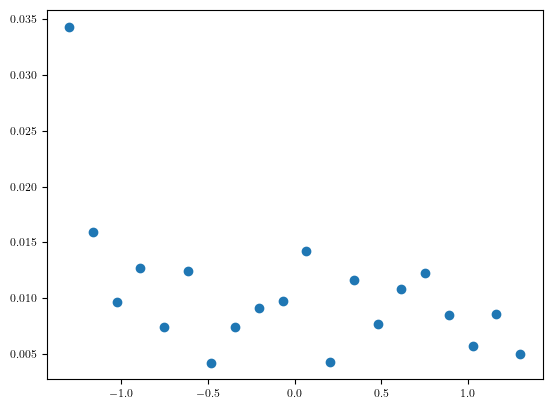

In [96]:
plt.scatter(x_grid.squeeze(), np.array(scores_cdf))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)


Running with 100 samples


/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=1000` reached.


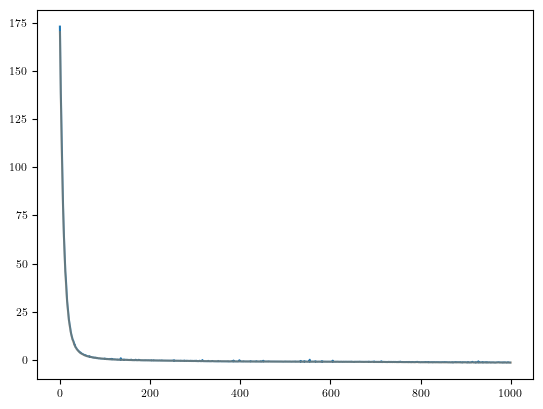

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 200 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


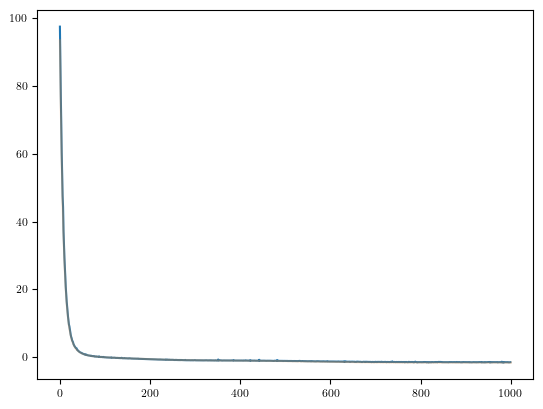

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 500 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


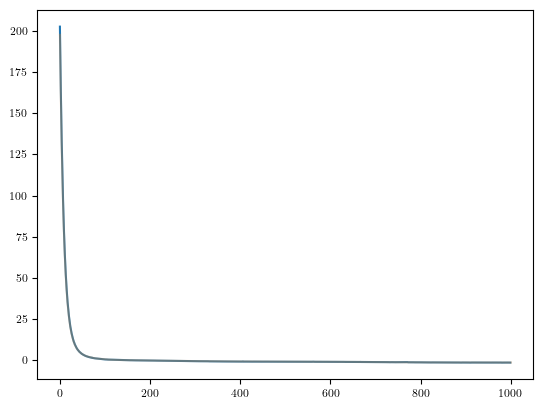

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 1000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


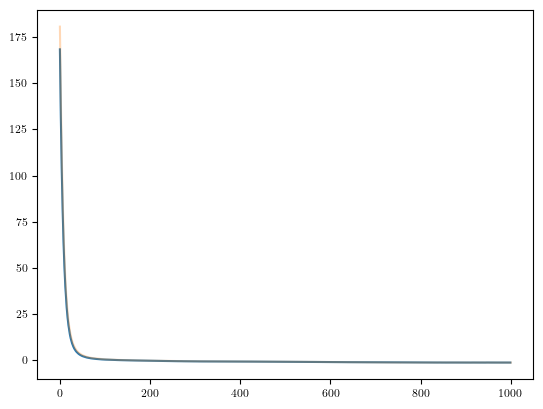

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 2000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


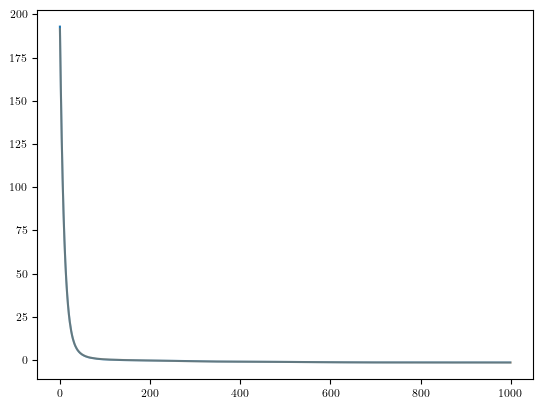

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 5000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


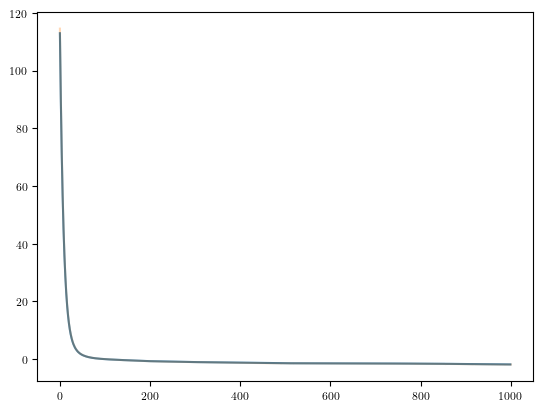

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 10000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


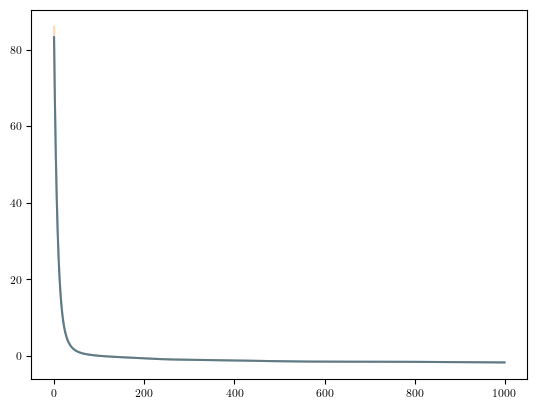

In [100]:
n_training_samples = [100, 200, 500, 1000, 2000, 5000, 10000]
lr = 1e-4
gamma = 1e-2
epochs = int(1e3)
models = []
for n in n_training_samples:
    print(f'Running with {n} samples')
    X_train, Y_train = X[:n], Y[:n]
    X_val, Y_val = X[Ntrain:Ntrain+Nval], Y[Ntrain:Ntrain+Nval]
    X_train = xscaler.fit_transform(X_train)
    Y_train = yscaler.fit_transform(Y_train)
    X_val = xscaler.transform(X_val)
    Y_val = yscaler.transform(Y_val)

    X_train_torch = frnp(X_train)
    Y_train_torch = frnp(Y_train)
    X_val_torch = frnp(X_val)
    Y_val_torch = frnp(Y_val)

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )
    
    train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
    val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

    trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 0,
    'enable_progress_bar': False,
    'devices': 1,
    })

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    models.append({
        'n_samples': n,
        'model': [NCP_module]
    })
    
    # plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
    # plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss))
    # plt.show()
    
models_df = pd.DataFrame(models)
models_df.to_pickle('linear_gaussian_models.pkl')

In [108]:
results = []
for model, n in zip(models, n_training_samples):
    NCP_model = model.model
    p10, p90 = np.percentile(X_train, [10, 90])
    x_grid = np.linspace(p10, p90, num=20)
    ys, step = np.linspace(-3, 3, num=1000, retstep=True)
    ys = frnp(ys.reshape(-1, 1))

    for postprocess in [None, 'centering', 'whitening']:
        scores_pdf = []
        scores_cdf = []
        for el in tqdm(x_grid, total=len(x_grid), desc='Evaluating model'):
            x_scaled = frnp([[el]])
            fys, pred_pdf = NCP_model.pdf(x_scaled, ys, postprocess=postprocess, p_y=p_y)
            fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
            true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform([[el]]), scale=sigma_sq).squeeze()
            pred_cdf = pdf2cdf(pred_pdf, step)
            true_cdf = norm.cdf(fys, loc=xscaler.inverse_transform([[el]]), scale=sigma_sq).squeeze()
            scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
            scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

        result = {
            'n_samples': n,
            'postprocess': str(postprocess),
            'scores_pdf': scores_pdf,
            'scores_cdf': scores_cdf
        }
        results.append(result)

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

In [109]:
results_df = pd.DataFrame(results)
results_df.to_pickle('linear_gaussian.pkl')

In [110]:
results_df

,n_samples,postprocess,scores_pdf,scores_cdf
0,100,None,"[0.9946309642945522, 1.0955241376851017, 1.130...","[0.17511342805995705, 0.18978716108997068, 0.1..."
1,100,centering,"[1.0818790476294757, 1.150797524436182, 1.1561...","[0.12344950246322596, 0.14407002897883936, 0.1..."
2,100,whitening,"[0.8423626952147538, 1.353015181061556, 1.4474...","[0.40360317179556837, 0.25760812436830655, 0.2..."
3,200,None,"[0.9489870379643822, 1.0634904003793788, 1.114...","[0.12549752497803404, 0.14765457638199755, 0.1..."
4,200,centering,"[1.0731976431009842, 1.1439118328108675, 1.147...","[0.09787485249605614, 0.13019686690807133, 0.1..."
5,200,whitening,"[0.39124462286566075, 0.501243371119747, 0.833...","[0.08073764026001788, 0.094882603208035, 0.130..."
6,500,None,"[1.1065968316571089, 1.2482841872247876, 1.328...","[0.10711096108113544, 0.13320565701663917, 0.1..."
7,500,centering,"[1.1145987827776809, 1.2381481325883854, 1.294...","[0.08992039602407663, 0.1237843699945547, 0.15..."
8,500,whitening,"[0.11564384001228614, 0.351080563276884, 0.356...","[0.1419022387817921, 0.08716560537500295, 0.06..."
9,1000,None,"[1.066863397115367, 1.2234238146706986, 1.3259...","[0.10550529769059874, 0.11953260634702885, 0.1..."


In [111]:
results_df = pd.read_pickle('linear_gaussian.pkl')
#take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
grouped_results= pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.mean(list(x))))
grouped_results.rename(columns={'scores_cdf': 'mean_scores_cdf'}, inplace=True)
grouped_results['std_scores_cdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.std(list(x)))
grouped_results['mean_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.mean(list(x)))
grouped_results['std_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.std(list(x)))
grouped_results = grouped_results.reset_index()
print(grouped_results)

    n_samples postprocess  mean_scores_cdf  std_scores_cdf  mean_scores_pdf  \
0         100        None         0.128188        0.035548         0.894622   
1         100   centering         0.112337        0.028361         1.032658   
2         100   whitening         0.420731        0.247123         1.499232   
3         200        None         0.104460        0.037913         1.044697   
4         200   centering         0.103673        0.037026         0.995809   
5         200   whitening         0.220479        0.142350         1.263204   
6         500        None         0.124936        0.043626         1.078524   
7         500   centering         0.116638        0.042978         1.060286   
8         500   whitening         0.099696        0.044347         0.895470   
9        1000        None         0.110967        0.037681         1.078300   
10       1000   centering         0.106252        0.035551         1.053511   
11       1000   whitening         0.049699        0.

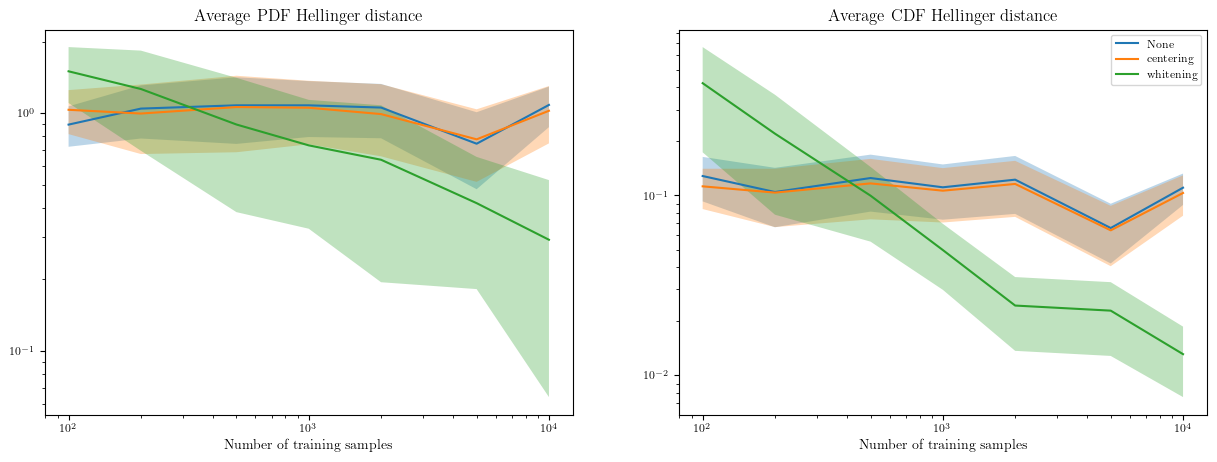

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for postprocess in ['None', 'centering', 'whitening']:
    ax = axs[0]
    n_samples = grouped_results[grouped_results['postprocess'] == postprocess]['n_samples']
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_pdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_pdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average PDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[1]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_cdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_cdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average CDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

plt.legend()
plt.show()

## ECON 

In [113]:
sigma_sq = 1
density_simulator = EconDensity(std= sigma_sq, heteroscedastic=True, random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

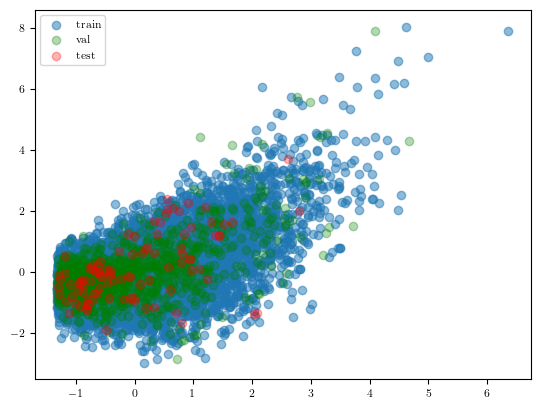

In [114]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [127]:
L.seed_everything(0)

lr = 1e-4
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs,
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': False,
}, callbacks=[LitProgressBar()])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [128]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
FIT Profiler Report
Profile stats for: [LightningModule]NCPModule.configure_callbacks
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 contextlib.py:141(__exit__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        1    0.000    0.000    0.000    0.000 profiler.py:55(profile)
        1    0.000    0.000    0.000    0.000 advanced.py:71(stop)
        1    0.000    0.000    0.000    0.000 module.py:923(configure_callbacks)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}



Profile stats for: [LightningModule]NCPModule.prepare_data
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumti

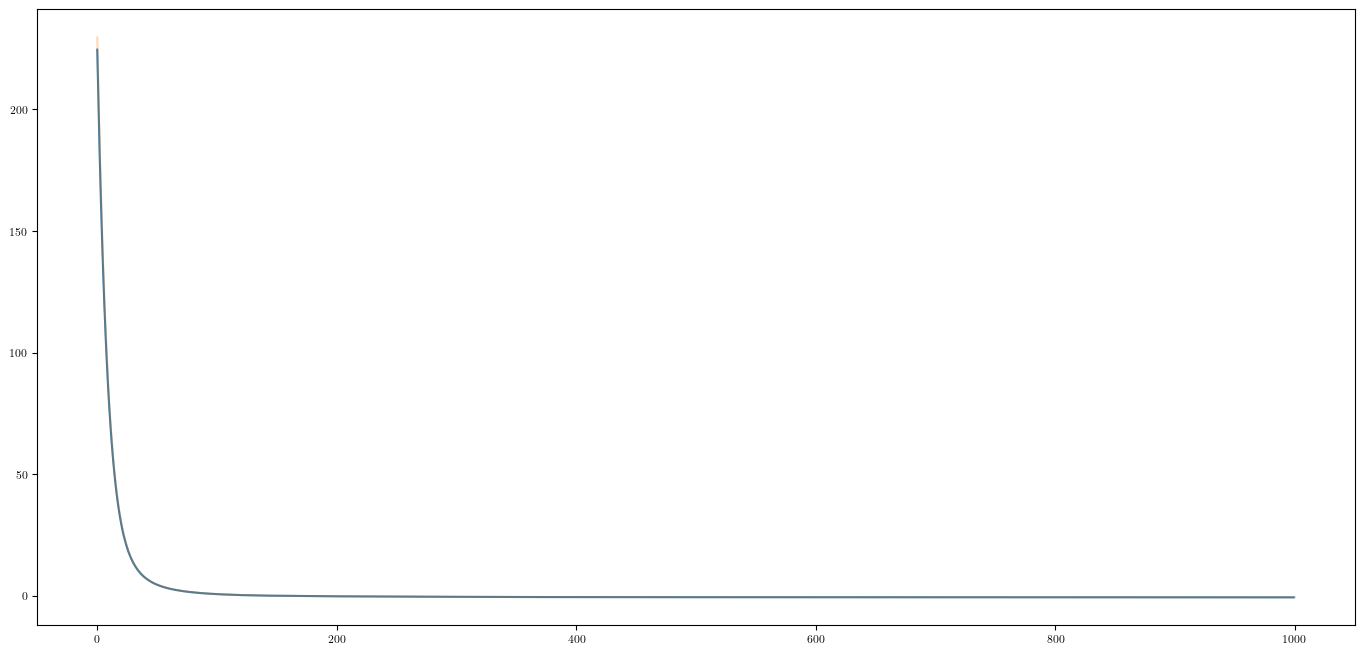

In [129]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
# plt.yscale('log')
plt.show()

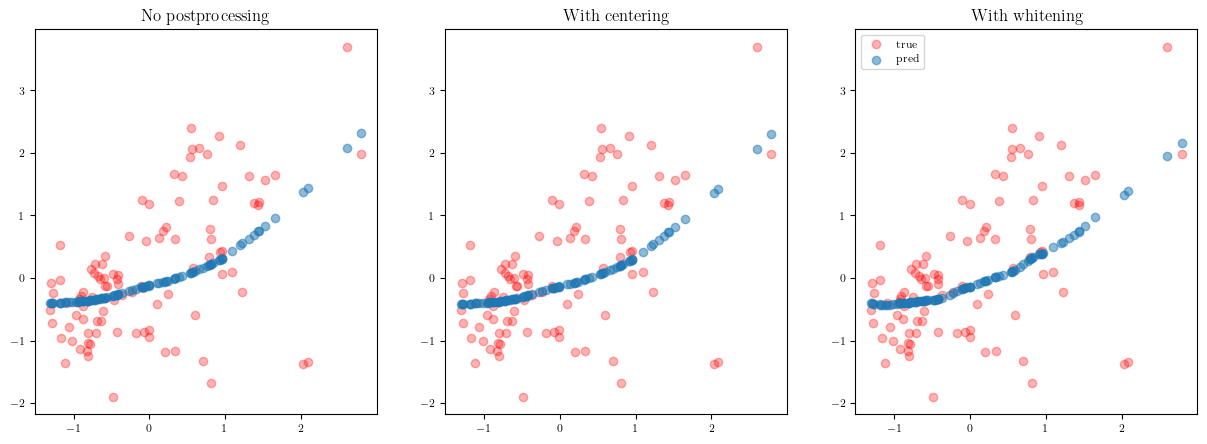

In [131]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

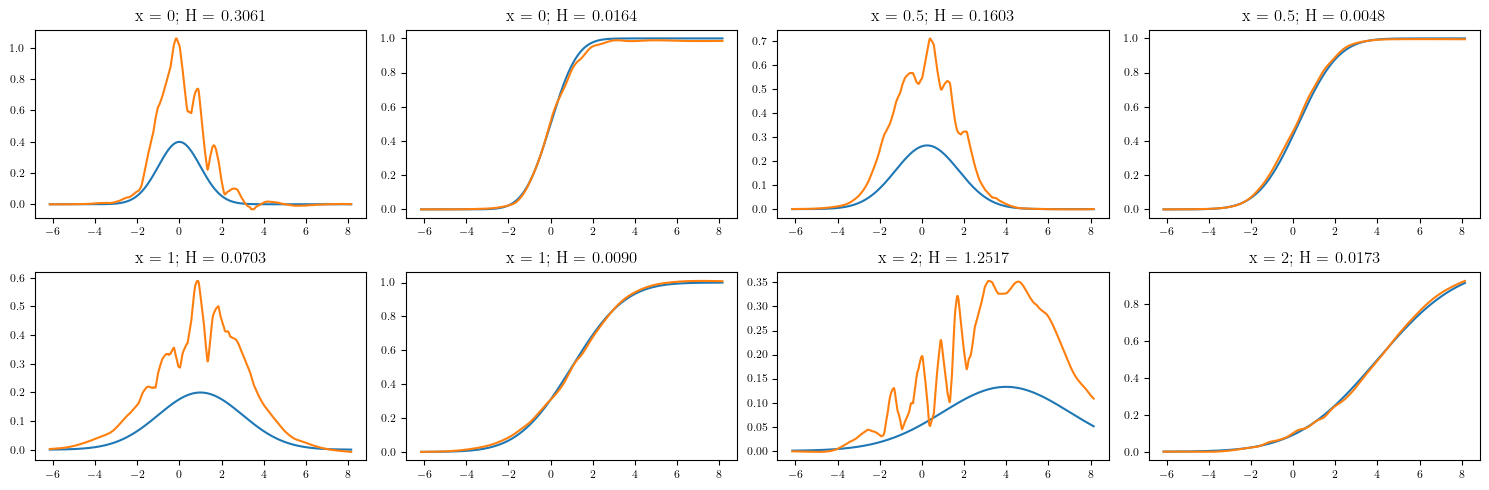

In [132]:
from NCP.cdf import compute_marginal
from NCP.metrics import *

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate([0, 0.5, 1, 2]):
    x_scaled = frnp(xscaler.transform([[xi]]))
    fys, pred_pdf = NCP_model.pdf(x_scaled, ys, postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    axes[i*2+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [137]:
p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=20)
ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'centering'
scores_pdf = []
scores_cdf = []
for el in x_grid:
    fys, pred_pdf = NCP_model.pdf(frnp([[el]]), ys, postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
    scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
    scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

In [138]:
print('Mean pdf hellinger distance: {0:.4f}'.format(np.mean(scores_pdf)))
print('Median pdf hellinger distance: {0:.4f}'.format(np.median(scores_pdf)))
print('Mean cdf hellinger distance: {0:.4f}'.format(np.mean(scores_cdf)))
print('Median cdf hellinger distance: {0:.4f}'.format(np.median(scores_cdf)))

Mean pdf hellinger distance: 0.1940
Median pdf hellinger distance: 0.1178
Mean cdf hellinger distance: 0.0219
Median cdf hellinger distance: 0.0212


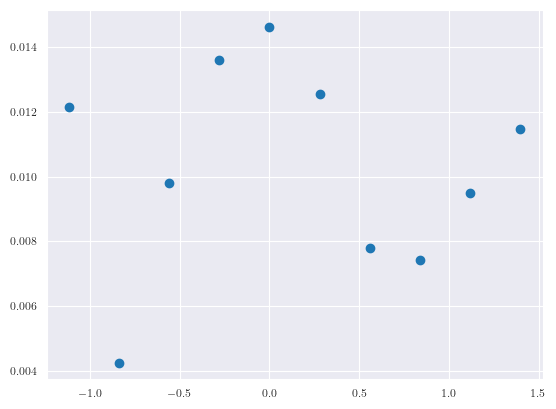

In [93]:
plt.scatter(x_grid.squeeze(), np.array(scores_cdf))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)


Running with 100 samples


/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=1000` reached.


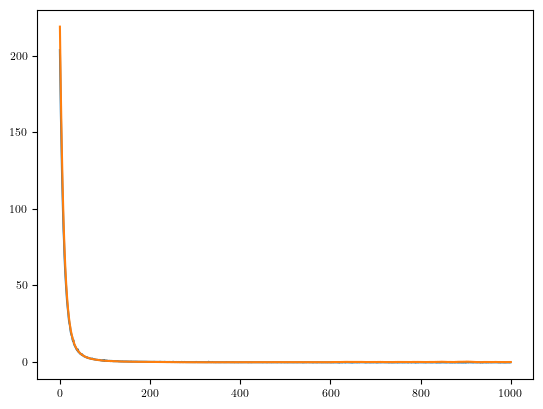

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 200 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


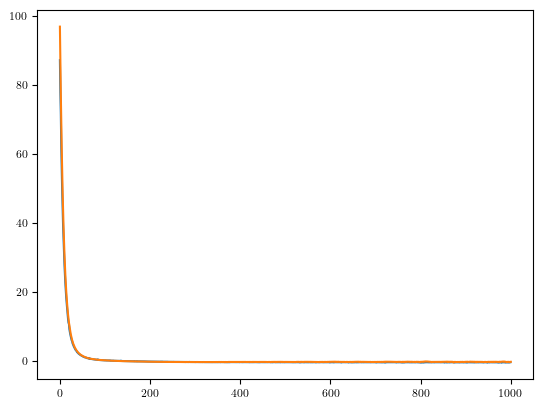

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 500 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


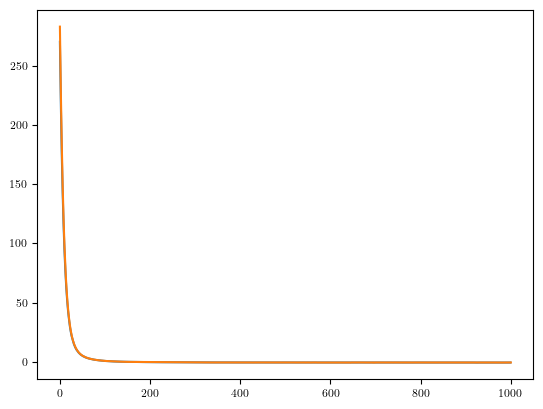

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 1000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


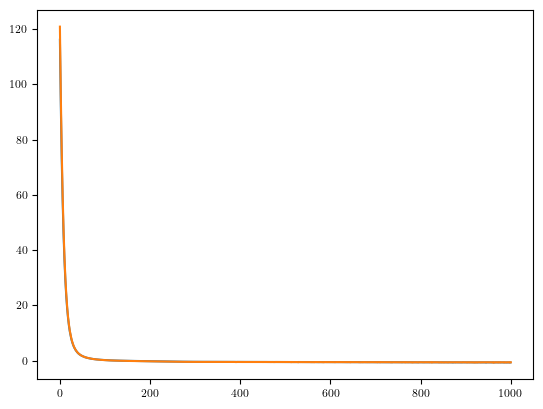

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 2000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


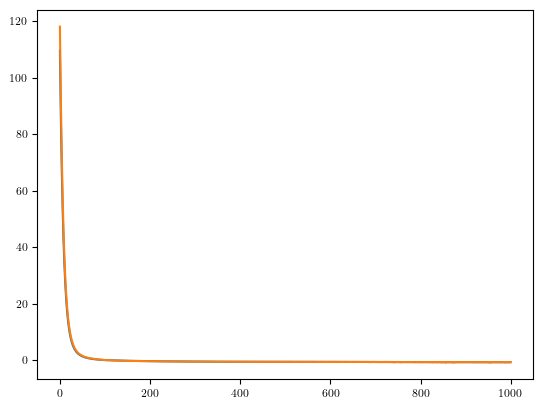

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 5000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


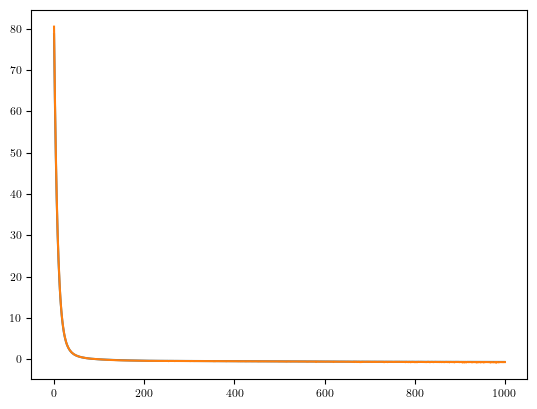

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 59.2 K
--------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Running with 10000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


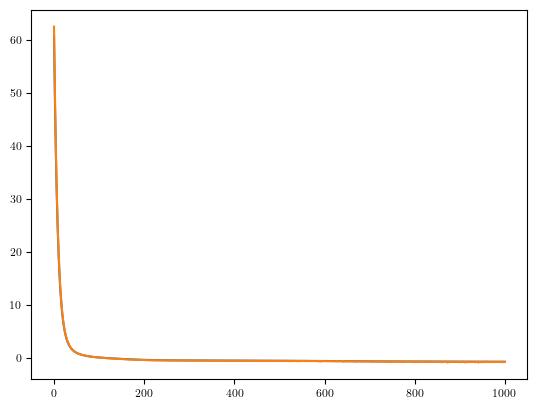

In [139]:
n_training_samples = [100, 200, 500, 1000, 2000, 5000, 10000]
lr = 1e-4
gamma = 1e-2
epochs = int(1e3)
models = []
for n in n_training_samples:
    print(f'Running with {n} samples')
    X_train, Y_train = X[:n], Y[:n]
    X_val, Y_val = X[Ntrain:Ntrain+Nval], Y[Ntrain:Ntrain+Nval]
    X_train = xscaler.fit_transform(X_train)
    Y_train = yscaler.fit_transform(Y_train)
    X_val = xscaler.transform(X_val)
    Y_val = yscaler.transform(Y_val)

    X_train_torch = frnp(X_train)
    Y_train_torch = frnp(Y_train)
    X_val_torch = frnp(X_val)
    Y_val_torch = frnp(Y_val)

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )
    
    train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
    val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

    trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 0,
    'enable_progress_bar': False,
    'devices': 1,
    'enable_checkpointing': False,
    })

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    models.append({
        'n_samples': n,
        'model': [NCP_module]
    })
    
    # plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
    # plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss))
    # plt.show()
    
models_df = pd.DataFrame(models)
models_df.to_pickle('ECON_models.pkl')

In [151]:
results = []
for row in tqdm(models_df.iterrows(), total=len(models_df), desc='Evaluating models'):
    n = row[1]['n_samples']
    model = row[1]['model'][0]
    NCP_model = model.model
    p10, p90 = np.percentile(X_train, [10, 90])
    x_grid = np.linspace(p10, p90, num=20)
    ys, step = np.linspace(-3, 3, num=1000, retstep=True)
    ys = frnp(ys.reshape(-1, 1))

    for postprocess in [None, 'centering', 'whitening']:
        scores_pdf = []
        scores_cdf = []
        for el in x_grid:
            fys, pred_pdf = NCP_model.pdf(frnp([[el]]), ys, postprocess=postprocess, p_y=p_y)
            fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
            true_pdf = density_simulator.pdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
            pred_cdf = pdf2cdf(pred_pdf, step)
            true_cdf = density_simulator.cdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
            scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
            scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

        result = {
            'n_samples': n,
            'postprocess': str(postprocess),
            'scores_pdf': scores_pdf,
            'scores_cdf': scores_cdf
        }
        results.append(result)

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model:   0%|          | 0/20 [00:00<?, ?it/s]

In [152]:
results_df = pd.DataFrame(results)
results_df.to_pickle('ECON.pkl')

In [153]:
results_df

,n_samples,postprocess,scores_pdf,scores_cdf
0,100,None,"[0.21656203051174974, 0.0998185538161751, 0.03...","[0.062263201223174997, 0.05060631693382543, 0...."
1,100,centering,"[0.2692220492526867, 0.14345839699708485, 0.06...","[0.04605627778740076, 0.03441617675631945, 0.0..."
2,100,whitening,"[0.11527789979040978, 0.6312133650567371, 0.80...","[0.06310795244514536, 0.30977149919014024, 0.7..."
3,200,None,"[0.38118674549029835, 0.22452500206429488, 0.1...","[0.04526838796874766, 0.035115794253820894, 0...."
4,200,centering,"[0.4043054274531774, 0.25946164769625135, 0.14...","[0.032991013833649406, 0.0234394450633508, 0.0..."
5,200,whitening,"[0.8319986920465714, 1.5862831495937972, 1.970...","[0.16426854456252893, 0.289146352982246, 0.307..."
6,500,None,"[0.2949797418055957, 0.15227772053810185, 0.04...","[0.02473367574753288, 0.021285081122608462, 0...."
7,500,centering,"[0.2706929431429341, 0.12308821295565493, 0.02...","[0.028522977002363743, 0.023772767792757128, 0..."
8,500,whitening,"[0.4373436296837371, 0.4215079245614699, 0.078...","[0.06350646673204173, 0.03496199779334786, 0.1..."
9,1000,None,"[0.4300564706259382, 0.28184067104716537, 0.16...","[0.023739855038324657, 0.01142354460687944, 0...."


In [154]:
results_df = pd.read_pickle('ECON.pkl')
#take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
grouped_results= pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.mean(list(x))))
grouped_results.rename(columns={'scores_cdf': 'mean_scores_cdf'}, inplace=True)
grouped_results['std_scores_cdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.std(list(x)))
grouped_results['mean_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.mean(list(x)))
grouped_results['std_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.std(list(x)))
grouped_results = grouped_results.reset_index()
print(grouped_results)

    n_samples postprocess  mean_scores_cdf  std_scores_cdf  mean_scores_pdf  \
0         100        None         0.023578        0.012816         0.145848   
1         100   centering         0.019634        0.008893         0.165030   
2         100   whitening         0.575977        0.177306         1.505514   
3         200        None         0.016122        0.009066         0.098202   
4         200   centering         0.013336        0.006371         0.118970   
5         200   whitening         0.288519        0.122050         1.374129   
6         500        None         0.015647        0.004433         0.169391   
7         500   centering         0.014260        0.005721         0.150658   
8         500   whitening         0.133038        0.078411         0.884491   
9        1000        None         0.009754        0.004596         0.153264   
10       1000   centering         0.008854        0.004521         0.144676   
11       1000   whitening         0.059047        0.

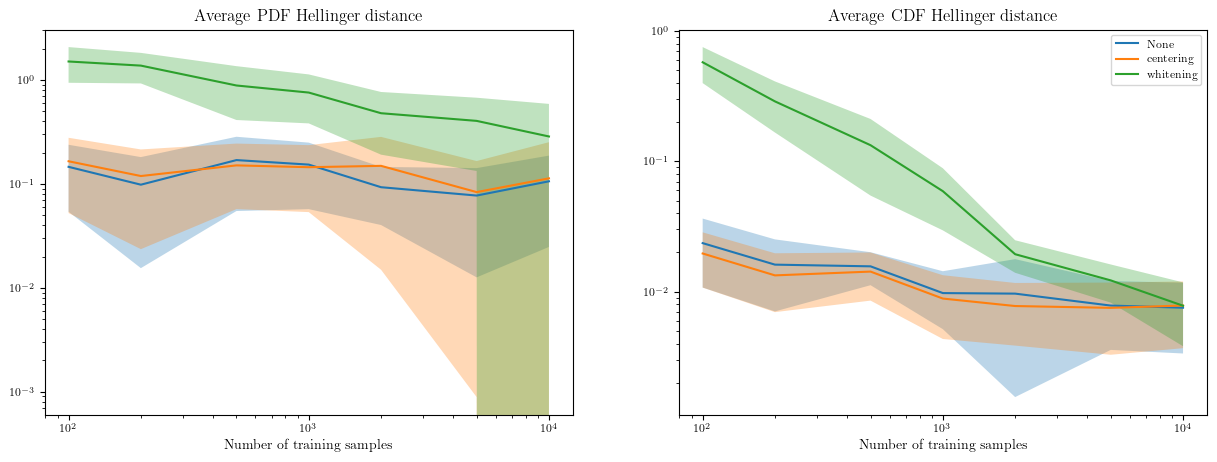

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for postprocess in ['None', 'centering', 'whitening']:
    ax = axs[0]
    n_samples = grouped_results[grouped_results['postprocess'] == postprocess]['n_samples']
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_pdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_pdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average PDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[1]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_cdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_cdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average CDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

plt.legend()
plt.show()

## ARMA Jump 

In [30]:
density_simulator = ArmaJump(random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = get_pdf(model, x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = density_simulator.pdf(xscaler.inverse_transform(x[..., None]), fys.reshape(1, -1))
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

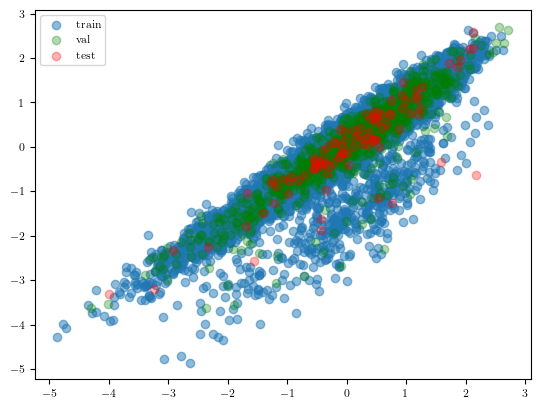

In [31]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [32]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 64,
    'lr': 1e-3,
    'gamma': 1e-3,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
S_layer = SingularLayer(config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
# model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)
NCP_operator = NCPOperator(U_operator, V_operator, S_layer)
model = DeepSVD(NCP_operator, gamma=config.gamma, device=device)

In [33]:
model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -4.093771457672119: 100%|██████████| 2000/2000 [00:26<00:00, 75.65it/s] 


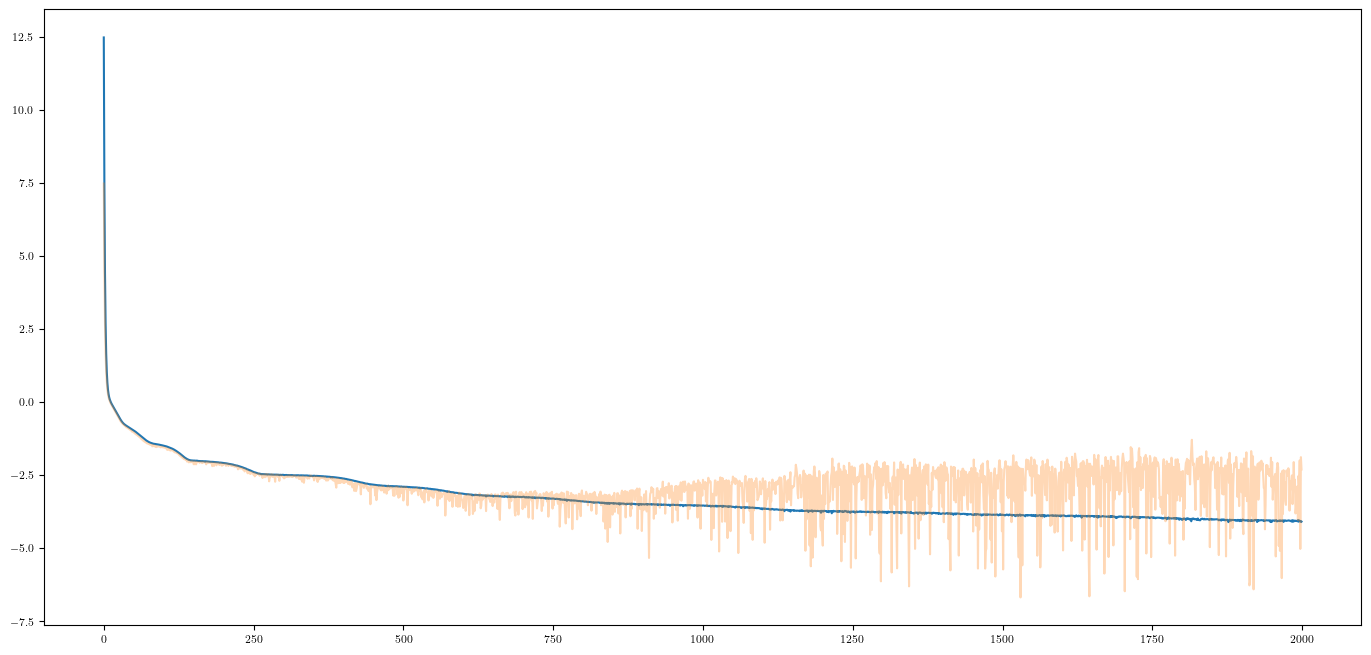

In [34]:
ls = model.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(model.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

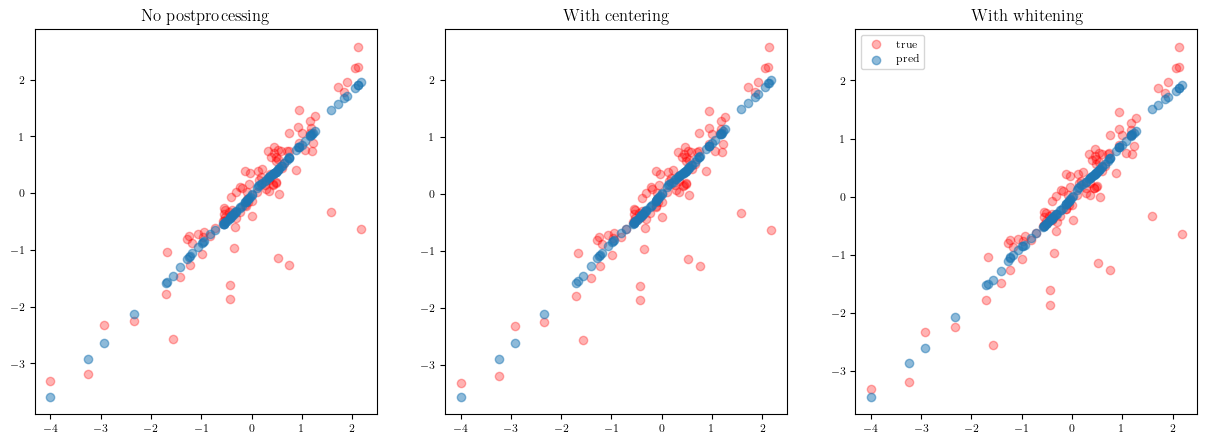

In [35]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = model.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = model.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = model.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

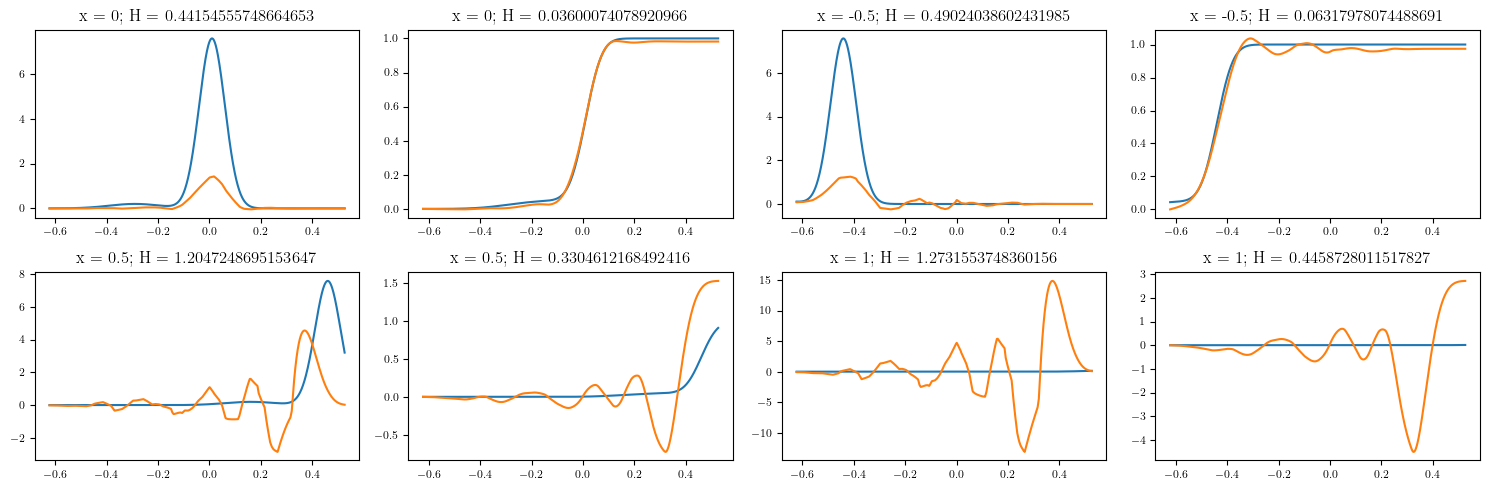

In [37]:
from scipy.stats import norm
from NCP.cdf import get_pdf
from NCP.metrics import *

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = ys.reshape(-1, 1)

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

for i, xi in enumerate([0, -0.5, 0.5, 1]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = model.pdf(x_scaled, ys, postprocess='centering', p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    # pred_pdf = normalize(pred_pdf)
    # true_pdf = normalize(true_pdf)
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; H = {1}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    axes[i*2+1].set_title(r'x = {0}; H = {1}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))
    
plt.tight_layout()
plt.show()

In [51]:
scores = empirical_KL(model, X_test, np.linspace(-2.5, 2.5, num=100).reshape(-1, 1))

100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


In [52]:
print(np.mean(scores))
print(np.median(scores))

0.2833804721686113
0.12423980639803367


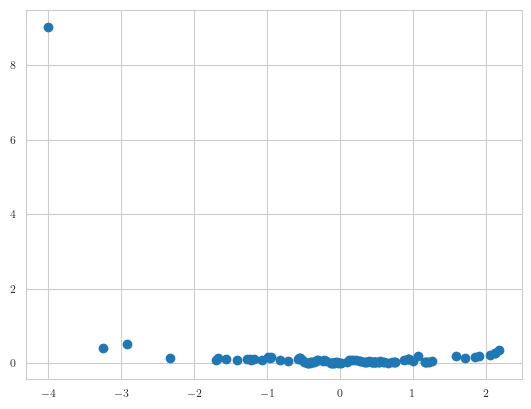

In [127]:
plt.scatter(X_test.squeeze(), np.array(scores))

## SkewNormal

In [4]:
density_simulator = SkewNormal(random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = get_pdf(model, x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = density_simulator.pdf(xscaler.inverse_transform(x[..., None]), fys.reshape(1, -1))
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

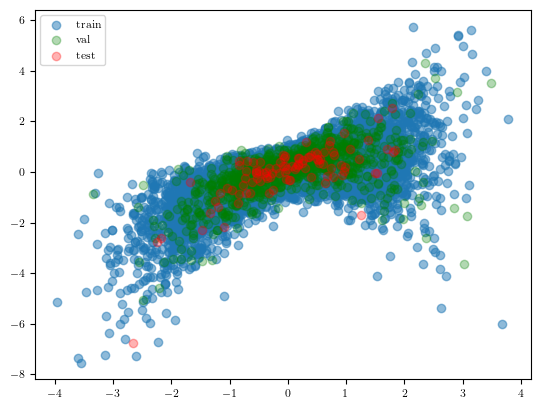

In [5]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [6]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 64,
    'lr': 1e-3,
    'gamma': 1e-3,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
S_layer = SingularLayer(config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
# model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)
NCP_operator = NCPOperator(U_operator, V_operator, S_layer)
model = DeepSVD(NCP_operator, gamma=config.gamma, device=device)

In [7]:
model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -1.463979721069336: 100%|██████████| 2000/2000 [00:26<00:00, 75.19it/s] 


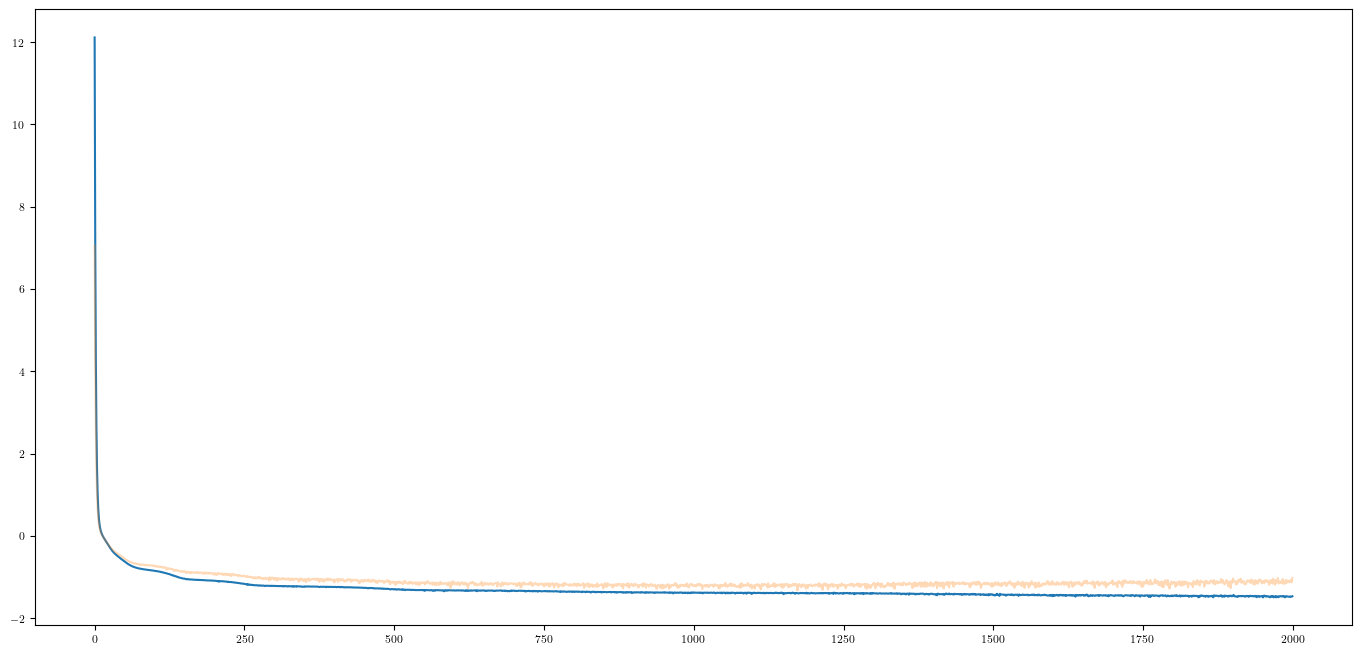

In [8]:
ls = model.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(model.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

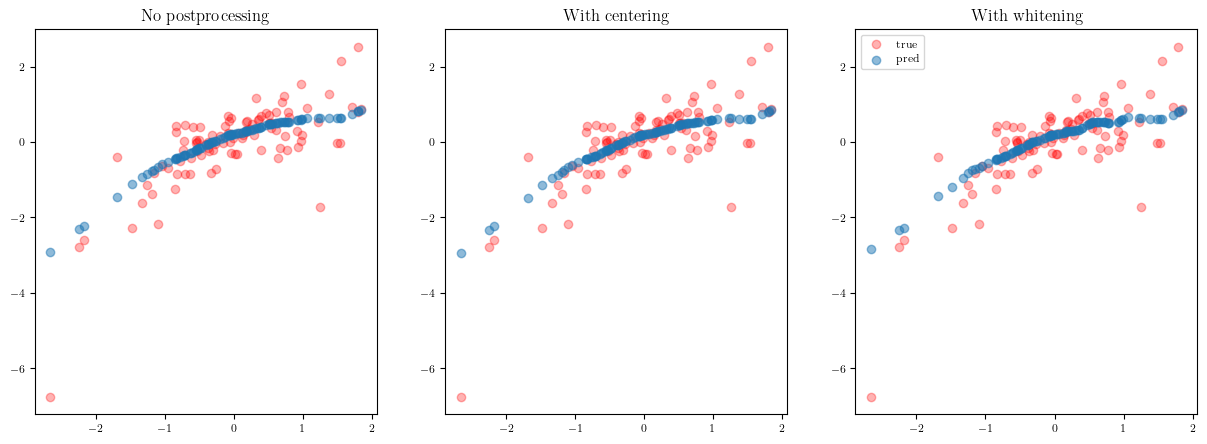

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = model.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = model.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = model.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

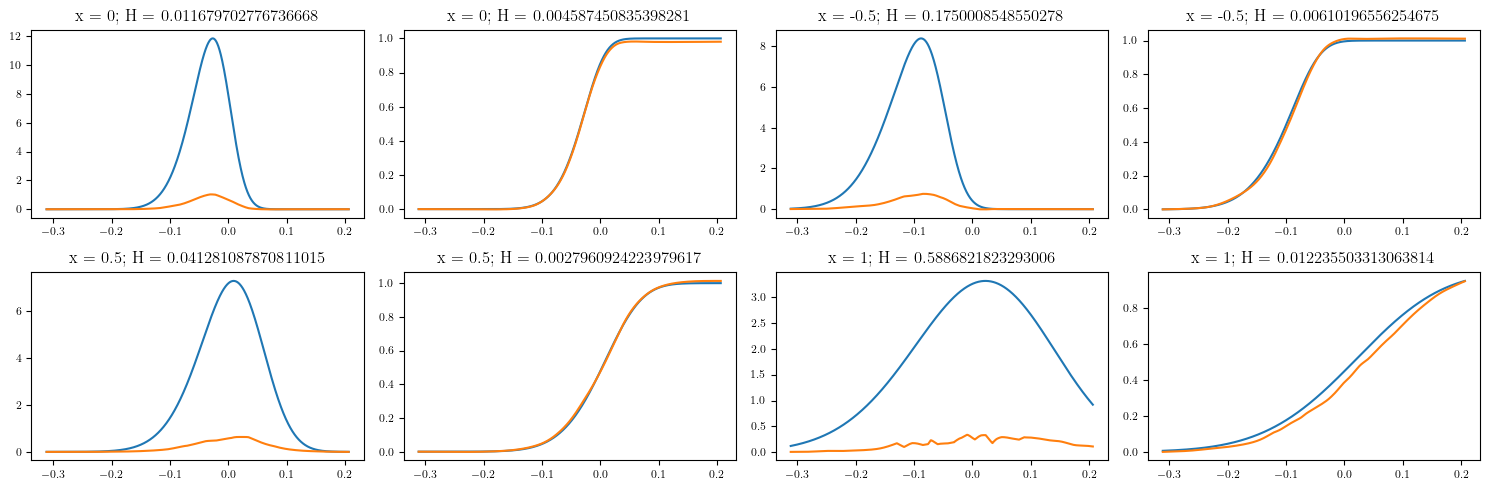

In [46]:
from scipy.stats import norm
from NCP.cdf import get_pdf
from NCP.metrics import *

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()

ys = np.linspace(-3, 3, num=1000).reshape(-1, 1)

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

for i, xi in enumerate([0, -0.5, 0.5, 1]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = model.pdf(x_scaled, ys, postprocess='centering', p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    # pred_pdf = normalize(pred_pdf)
    # true_pdf = normalize(true_pdf)
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; H = {1}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    axes[i*2+1].set_title(r'x = {0}; H = {1}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))
    
plt.tight_layout()
plt.show()

In [16]:
scores = empirical_KL(model, X_test, np.linspace(-2.5, 2.5, num=100).reshape(-1, 1))

100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


In [17]:
print(np.mean(scores))
print(np.median(scores))

0.023775023410084382
0.015051862462094657


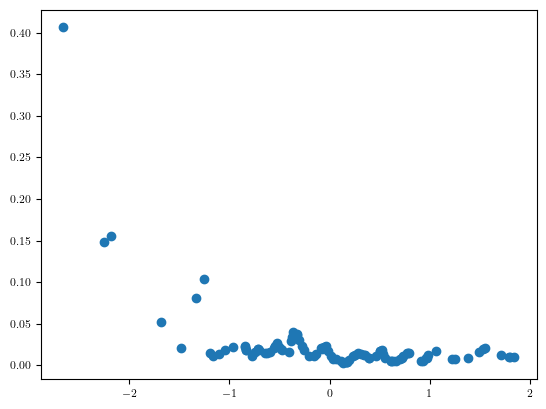

In [18]:
plt.scatter(X_test.squeeze(), np.array(scores))